## Baseline code for the Forecast on Market Data

In [ ]:
# import necessary libraries

import numpy as np 
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from metrics import measure_performance
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [4]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

/Users/oyekanmiolatunde/miniconda3/envs/autolguon_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the data

In [112]:
x_train = pd.read_csv('data/x_train.csv', index_col='timestamp').reset_index()
x_test = pd.read_csv('data/x_test.csv', index_col='timestamp').reset_index()
y_train = pd.read_csv('data/y_train.csv', index_col='timestamp').reset_index()
y_test = pd.read_csv('data/y_test.csv', index_col='timestamp').reset_index()

data = pd.read_csv('data/whole_data.csv', index_col='timestamp')

In [113]:
x_train["timestamp"] = pd.to_datetime(x_train["timestamp"])
x_test["timestamp"] = pd.to_datetime(x_test["timestamp"])
y_train["timestamp"] = pd.to_datetime(y_train["timestamp"])
y_test["timestamp"] = pd.to_datetime(y_test["timestamp"])

### Prepare data for Autogluon TS

- Independent target variable forecast: y1

In [72]:
x_train["item_id"]="BTCUSDT"
dataset_train = x_train.merge(y_train.iloc[:,:2], on="timestamp", how="left")
dataset_train_df = dataset_train.rename(columns={"y1":"target"})
dataset_train_df.head()

,timestamp,x1,x2,x3,x4,x5,x6,x7,x8,x9,item_id,target
0,1970-01-01 00:28:40.782000,1.000954,1.000704,0.999855,0.998924,-0.264794,0.172140,0.814119,0.950355,-0.001926,BTCUSDT,0.015632
1,1970-01-01 00:28:40.785600,1.002561,1.002941,1.002401,1.001638,0.133313,0.410012,1.063420,1.047122,-0.001957,BTCUSDT,0.013582
2,1970-01-01 00:28:40.789200,1.007068,1.009000,1.009156,1.008776,0.686941,0.486802,1.047105,0.975720,-0.002476,BTCUSDT,0.007839
3,1970-01-01 00:28:40.792800,1.004512,1.007119,1.007754,1.007676,1.336274,0.572887,1.025864,1.015855,-0.003001,BTCUSDT,-0.004401
4,1970-01-01 00:28:40.796400,1.007487,1.011342,1.012696,1.013063,0.421036,0.584342,1.044123,1.048774,-0.003834,BTCUSDT,-0.011764


In [73]:
dataset_train_df.head()

,timestamp,x1,x2,x3,x4,x5,x6,x7,x8,x9,item_id,target
0,1970-01-01 00:28:40.782000,1.000954,1.000704,0.999855,0.998924,-0.264794,0.172140,0.814119,0.950355,-0.001926,BTCUSDT,0.015632
1,1970-01-01 00:28:40.785600,1.002561,1.002941,1.002401,1.001638,0.133313,0.410012,1.063420,1.047122,-0.001957,BTCUSDT,0.013582
2,1970-01-01 00:28:40.789200,1.007068,1.009000,1.009156,1.008776,0.686941,0.486802,1.047105,0.975720,-0.002476,BTCUSDT,0.007839
3,1970-01-01 00:28:40.792800,1.004512,1.007119,1.007754,1.007676,1.336274,0.572887,1.025864,1.015855,-0.003001,BTCUSDT,-0.004401
4,1970-01-01 00:28:40.796400,1.007487,1.011342,1.012696,1.013063,0.421036,0.584342,1.044123,1.048774,-0.003834,BTCUSDT,-0.011764


In [99]:
# create a list of known covariates
known_covariates = [f"x{i+1}" for i in range(9)]
known_covariates

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']

In [94]:
# create a timeseries dataframe
TS_df = TimeSeriesDataFrame.from_data_frame(
    dataset_train_df,
    id_column="item_id",
    timestamp_column="timestamp",

)

In [139]:
#create the predictor object
predictor = TimeSeriesPredictor(
    prediction_length=len(x_test),
    target="target",
    known_covariates_names=known_covariates,
    eval_metric="MASE"
)

predictor.fit(TS_df, presets="medium_quality",
                )

Beginning AutoGluon training...
AutoGluon will save models to '/Users/oyekanmiolatunde/Desktop/Market-Data-Forecasting/AutogluonModels/ag-20250216_174640'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.8
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.3.0: Thu Jan  2 20:24:16 PST 2025; root:xnu-11215.81.4~3/RELEASE_ARM64_T6000
CPU Count:          10
GPU Count:          0
Memory Avail:       4.15 GB / 16.00 GB (25.9%)
Disk Space Avail:   623.31 GB / 926.35 GB (67.3%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'light',
 'known_covariates_names': ['x1',
                            'x2',
                            'x3',
                            'x4',
                            'x5',
                            'x6',
                            'x7',
                            'x8',
                

## Make predictions

#### Generate known covariates for the forecast horizon

In [143]:
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe

future_index = get_forecast_horizon_index_ts_dataframe(TS_df, 
                                        prediction_length=len(x_test),
                                        )

future_timestamps = future_index.get_level_values("timestamp")
known_covariates_df = pd.DataFrame(index=future_index)

In [144]:
for col in known_covariates:
    known_covariates_df[col] = x_test[col].values

In [145]:
known_covariates_df

x1        x2        x3        x4  \
item_id timestamp                                                            
BTCUSDT 1970-01-01 00:28:54.969600  1.005697  1.011580  1.017120  1.021281   
        1970-01-01 00:28:54.973200  1.003126  1.008635  1.014066  1.018299   
        1970-01-01 00:28:54.976800  1.000462  1.005058  1.010141  1.014301   
        1970-01-01 00:28:54.980400  0.997376  1.000527  1.004989  1.008901   
        1970-01-01 00:28:54.984000  0.999228  1.001635  1.005654  1.009387   
...                                      ...       ...       ...       ...   
        1970-01-01 00:28:58.526400  0.997863  1.003670  1.010514  1.015533   
        1970-01-01 00:28:58.530000  0.997157  1.001257  1.007312  1.012085   
        1970-01-01 00:28:58.533600  0.994198  0.996232  1.001241  1.005573   
        1970-01-01 00:28:58.537200  0.988175  0.987180  0.990647  0.994211   
        1970-01-01 00:28:58.540800  0.995443  0.993594  0.996205  0.999319   

                                          x5        x6        x7        x8  \
item_id timestamp                                                            
BTCUSDT 1970-01-01 00:28:54.969600 -0.345966 -0.484929  1.172840  1.057643   
        1970-01-01 00:28:54.973200 -0.453436 -0.586331  1.117737  1.018839   
        1970-01-01 00:28:54.976800 -0.435214 -0.577529  0.844409  1.039954   
        1970-01-01 00:28:54.980400 -0.466402 -0.595023  0.712512  0.951988   
        1970-01-01 00:28:54.984000 -0.274633 -0.555870  0.830935  0.870036   
...                                      ...       ...       ...       ...   
        1970-01-01 00:28:58.526400 -0.355241 -0.540296  0.935159  0.970050   
        1970-01-01 00:28:58.530000 -0.283947 -0.616398  0.918955  0.863609   
        1970-01-01 00:28:58.533600 -0.123984 -0.496313  0.637781  0.775180   
        1970-01-01 00:28:58.537200  1.247309  0.005502  0.873671  0.903055   
        1970-01-01 00:28:58.540800  1.732179  0.292583  0.949725  0.916275   

                                          x9  
item_id timestamp                             
BTCUSDT 1970-01-01 00:28:54.969600  0.007608  
        1970-01-01 00:28:54.973200  0.007421  
        1970-01-01 00:28:54.976800  0.007104  
        1970-01-01 00:28:54.980400  0.006523  
        1970-01-01 00:28:54.984000  0.005993  
...                                      ...  
        1970-01-01 00:28:58.526400  0.000509  
        1970-01-01 00:28:58.530000  0.001557  
        1970-01-01 00:28:58.533600  0.001840  
        1970-01-01 00:28:58.537200  0.001806  
        1970-01-01 00:28:58.540800  0.001666  

[993 rows x 9 columns]

In [146]:
predictions= predictor.predict(TS_df, 
        known_covariates=known_covariates_df)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [147]:
desired_forecast_quantile = "0.9"
forecast = predictions[desired_forecast_quantile].values
forecast

array([0.00549501, 0.00633048, 0.00659917, 0.00727983, 0.00837915,
       0.00891015, 0.0092447 , 0.00861849, 0.00880042, 0.00931912,
       0.0104029 , 0.0104392 , 0.01271321, 0.01343604, 0.01585566,
       0.01400354, 0.01447044, 0.01194756, 0.01184093, 0.01080206,
       0.01141012, 0.01175121, 0.01283224, 0.01407033, 0.01490584,
       0.01535473, 0.01610128, 0.0164154 , 0.0157837 , 0.01563944,
       0.01499069, 0.01383898, 0.01330226, 0.01371819, 0.01706906,
       0.01743203, 0.01786811, 0.01573662, 0.01502901, 0.01183067,
       0.01312902, 0.01367308, 0.01423657, 0.01398462, 0.01441101,
       0.01307893, 0.01296518, 0.01285517, 0.01247789, 0.01273111,
       0.01347111, 0.01415935, 0.01550416, 0.01600676, 0.01532675,
       0.01435397, 0.01424921, 0.0164183 , 0.01708318, 0.01861067,
       0.01797209, 0.01752166, 0.01360139, 0.0134874 , 0.0135458 ,
       0.01498067, 0.01502226, 0.01487846, 0.01365396, 0.01269655,
       0.01100899, 0.01080733, 0.01021666, 0.01033747, 0.01040

## Calculate metrics 

In [148]:
y_test

,timestamp,y1,y2,y3
0,1970-01-01 00:28:55.077600,-0.007375,-0.006891,-0.003078
1,1970-01-01 00:28:55.081200,-0.004416,-0.004850,0.000411
2,1970-01-01 00:28:55.084800,-0.001507,0.000173,0.001070
3,1970-01-01 00:28:55.088400,-0.000953,-0.000681,0.004392
4,1970-01-01 00:28:55.092000,-0.000514,0.000410,0.004407
...,...,...,...,...
988,1970-01-01 00:28:58.634400,-0.024159,-0.014844,-0.016680
989,1970-01-01 00:28:58.638000,-0.023659,-0.016331,-0.012229
990,1970-01-01 00:28:58.641600,-0.017153,-0.000656,-0.012038
991,1970-01-01 00:28:58.645200,-0.000690,0.004970,-0.002246


In [161]:
def plot_predictions(y_test, y_pred, target, title=None):
    """
    Plot actual vs. predicted values for the specified target.
    
    Parameters:
        y_test (pd.DataFrame): Test targets (multiple columns expected).
        y_pred (np.array): Predictions from the model.
        target (str): The target column to plot.
        title (str): Plot title (optional).
    """
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test[target], label='Actual', marker='o')
    plt.plot(y_test.index, y_pred, label='Predicted', marker='x')
    plt.xlabel("Time")
    plt.ylabel("Log Returns")
    if title is None:
        title = f"Autogluon TS: Actual vs Predicted Log Returns for {target}"
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

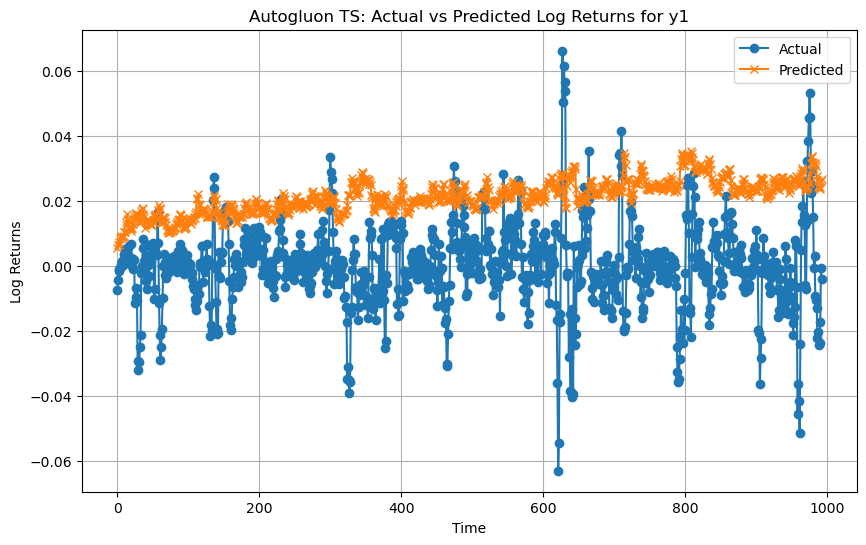

In [162]:
plot_predictions(y_test,forecast, target="y1")

In [160]:
compute_directional_metrics(y_test,forecast, target="y1")

/Users/oyekanmiolatunde/miniconda3/envs/autolguon_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/oyekanmiolatunde/miniconda3/envs/autolguon_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/oyekanmiolatunde/miniconda3/envs/autolguon_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

(0.5065458207452165,
 array([[  0, 490],
        [  0, 503]]),
 '              precision    recall  f1-score   support\n\n    Negative       0.00      0.00      0.00       490\n    Positive       0.51      1.00      0.67       503\n\n    accuracy                           0.51       993\n   macro avg       0.25      0.50      0.34       993\nweighted avg       0.26      0.51      0.34       993\n')

## Fit Autogluon Tabular

In [151]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [153]:
## prepare data
tab_data_train = pd.concat([x_train[known_covariates],y_train["y1"]], axis=1)
X_train_tabular  = TabularDataset(tab_data_train)

tab_predictor = TabularPredictor(label="y1").fit(X_train_tabular)

X_test_tabular = TabularDataset(x_test[known_covariates])

y_pred = tab_predictor.predict(X_test_tabular)

No path specified. Models will be saved in: "AutogluonModels/ag-20250216_230759"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.8
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.3.0: Thu Jan  2 20:24:16 PST 2025; root:xnu-11215.81.4~3/RELEASE_ARM64_T6000
CPU Count:          10
Memory Avail:       6.40 GB / 16.00 GB (40.0%)
Disk Space Avail:   619.52 GB / 926.35 GB (66.9%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy

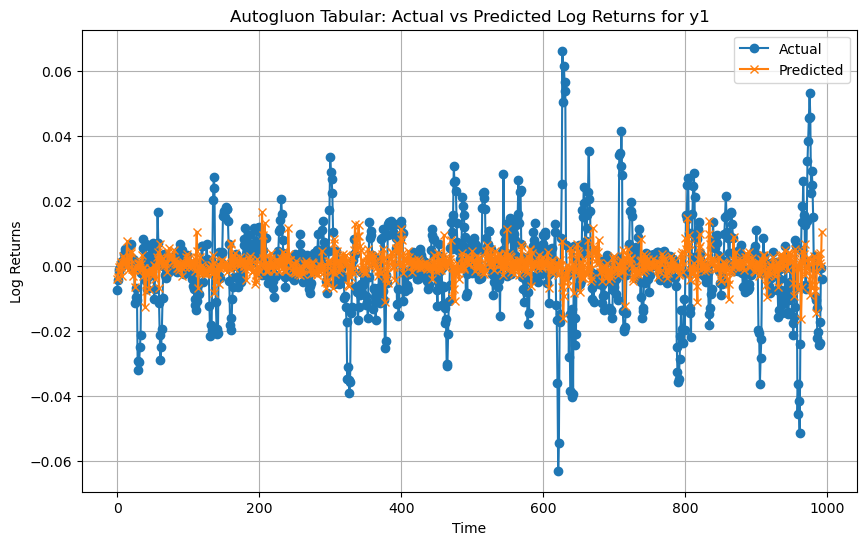

In [163]:
plot_predictions(y_test,y_pred, target="y1", title="Autogluon Tabular: Actual vs Predicted Log Returns for y1")

### Validate Model

In [156]:
def compute_directional_metrics(y_test, y_pred, target):
    """
    Compute directional predictions, accuracy, confusion matrix, and classification report.
    
    Parameters:
        y_test (pd.DataFrame): Test targets.
        y_pred (np.array): Predictions from the model.
        target (str): The target column for evaluation.
        
    Returns:
        directional_accuracy (float): Proportion of correct directional predictions.
        conf_mat (np.array): Confusion matrix.
        class_report (str): Classification report.
    """
    # Convert continuous values to direction (-1 or +1)
    y_test_direction = np.where(y_test[target] >= 0, 1, -1)
    y_pred_direction = np.where(y_pred >= 0, 1, -1)
    directional_accuracy = np.mean(y_test_direction == y_pred_direction)
    
    conf_mat = confusion_matrix(y_test_direction, y_pred_direction)
    class_report = classification_report(y_test_direction, y_pred_direction, target_names=["Negative", "Positive"])
    
    return directional_accuracy, conf_mat, class_report

In [159]:
compute_directional_metrics(y_test,y_pred, target="y1")

(0.4904330312185297,
 array([[205, 285],
        [221, 282]]),
 '              precision    recall  f1-score   support\n\n    Negative       0.48      0.42      0.45       490\n    Positive       0.50      0.56      0.53       503\n\n    accuracy                           0.49       993\n   macro avg       0.49      0.49      0.49       993\nweighted avg       0.49      0.49      0.49       993\n')